In [39]:
# our modules: 
import sys
sys.path.append('../modules/')

from subprocess import Popen
import subprocess as sp
import os
from importlib import reload

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ffmpy
from IPython.display import HTML
%matplotlib inline

# sonification modules
import notepicker
import writeCmixSco_WT_ac as wRT_wt
#import makeDataChord_v2 as mDc
#import writeCmixSco_GRAN_v2 as wRT_gran

# this tells the notebook kernel to use the graphics engine in the OS
%matplotlib auto 

# the animation modules from matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib import cm # colormap
from matplotlib import rc

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

Using matplotlib backend: Qt5Agg
CMIX found.


### The steps: 
(1) read in the data <br>
(2) animation <br>
(3) sonification <br>
(4) combine into a movie <br>

## (1) read in the data

In [5]:
# read in two data streams: 
datafilename = '../data/breathalyzer/y2020-02-13_tsawi0_37s.pkl'
breath = pd.read_pickle(datafilename)

Ltemp_C = np.array(breath.temp_C)
Lhumidity = np.array(breath.hum)

datafilename = '../data/breathalyzer/y2020-02-13_chris0_37s.pkl'
breath = pd.read_pickle(datafilename)

Rtemp_C = np.array(breath.temp_C)
Rhumidity = np.array(breath.hum)

# time in these two is the same, otherwise it would be necessary to interpolate both datasets to the same number of points. 
time = np.array(breath.time_s)
time_ind_vec = np.arange(0, len(time)-1)

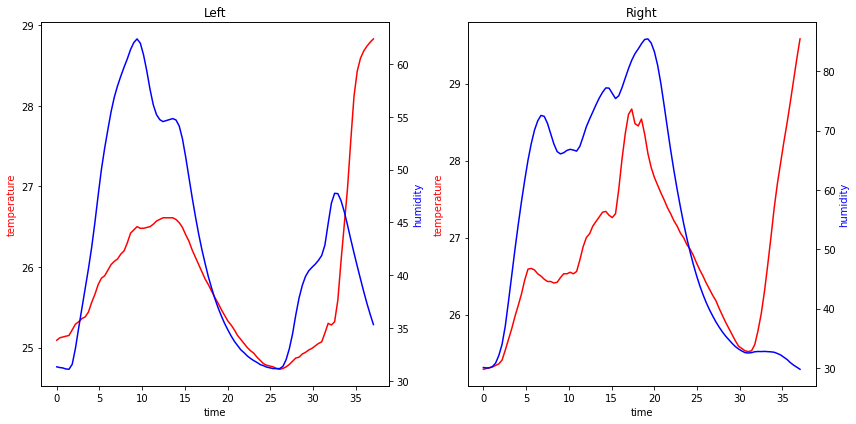

In [10]:
%matplotlib inline
fig0,(axLd,axRd) = plt.subplots(1,2,figsize = (12,6))
# axLd = fig0.add_subplot(121)
# axRd = fig0.add_subplot(122)

axLd.plot(time,Ltemp_C, 'r')
axLd.set_xlabel('time')
axLd.set_ylabel('temperature', color='r')
axLd.set_title('Left')
axLd2 = axLd.twinx()
axLd2.plot(time,Lhumidity, 'b')
axLd2.set_ylabel('humidity', color='b')

axRd.plot(time,Rtemp_C, 'r')
axRd.set_xlabel('time')
axRd.set_ylabel('temperature', color='r')
axRd.set_title('Right')
axRd2 = axRd.twinx()
axRd2.plot(time,Rhumidity, 'b')
axRd2.set_ylabel('humidity', color='b')
fig0.tight_layout() 


## (2) the animation: two dots, two breaths, from previous notebook

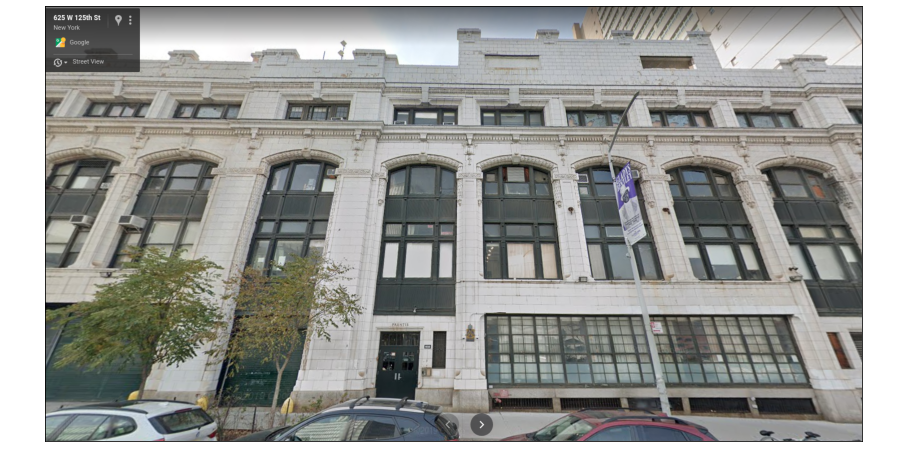

In [12]:

import matplotlib.image as mpimg

# ==================================================
# read in the background image
bg_image = '../data/Prentis.png'
img=mpimg.imread(bg_image)
sz_x,sz_y,col_depth = img.shape
#print(sz_x,sz_y,col_depth)


figA, ax = plt.subplots(figsize=(16,8))
ax.imshow(img) #, extent=[0, 400, 0, 300]) to crop the image and change its location
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# now add axes on top of the image for the dots
axL = figA.add_subplot(121, aspect='equal')
axR = figA.add_subplot(122, aspect='equal')

#(x,y) of the lower left corner, width, height
axL.get_xaxis().set_visible(False)
axL.get_yaxis().set_visible(False)
#axL.patch.set_facecolor('red')
axL.patch.set_alpha(0.0)
axL.set_frame_on(False)

#bg_squareR = patches.Rectangle((1.0, 1.0),1.0,1.0,facecolor="blue", fill=True)
axR.get_xaxis().set_visible(False)
axR.get_yaxis().set_visible(False)
axR.patch.set_alpha(0.0)
#axR.add_patch(bg_squareR)
axR.set_frame_on(False)

# initialize the dot patches ! 
Lcirc = patches.Circle((0.6, 0.5),0.2,facecolor="red")
Rcirc = patches.Circle((0.4, 0.5),0.2,facecolor="black")


In [24]:
ind = 25
num_vals = 10

humidity_all = np.hstack((Rhumidity,Lhumidity))
temp_all = np.hstack((Ltemp_C,Rtemp_C))
# =====================
# MAP HUMIDITY TO RADIUS
humid_vec = np.linspace(np.min(humidity_all),np.max(humidity_all),num_vals)

def scale_radius(humidity_val):
    min_rad = 0.1
    max_rad = 0.4
    radius_vec = np.linspace(min_rad,max_rad,num_vals)
    rad_val = np.interp(humidity_val,humid_vec,radius_vec)
    return rad_val

rad_val_0 = scale_radius(Lhumidity[ind])
print('rad_val = ' + str(rad_val_0))

# =====================
# MAP TEMPERATURE TO COLOR
temp_vec = np.linspace(np.min(temp_all),np.max(temp_all),num_vals)

def color_getter(temp_val):
    #cmap = plt.get_cmap('inferno')
    cmap = cm.hot
    color_vec = np.linspace(0,1,num_vals)
    color_ind = np.interp(temp_val,temp_vec,color_vec)
    dot_col_T = cmap(color_ind)
    return dot_col_T

col0 = color_getter(Ltemp_C[ind])
print('dot_col_T = ' + str(col0) )

# ===================================================
# initialize what will move in the animation
def init():
    colL = []
    colL = color_getter(Ltemp_C[0])
    radL = scale_radius(Lhumidity[0])
    Lcirc.radius = radL
    Lcirc.set_color(colL)
    axL.add_artist(Lcirc)
    
    colR = []
    colR = color_getter(Rtemp_C[0])
    radR = scale_radius(Rhumidity[0])
    Rcirc.radius = radR
    Rcirc.set_color(colR)
    axR.add_artist(Rcirc)
    
    return Lcirc, Rcirc,

# ===================================================
# define what will change for one element
def animateLEFT(i): # is this (i) needed for the animate function ? 
    col = []
    col = color_getter(Ltemp_C[i])
    rad = scale_radius(Lhumidity[i])
    Lcirc.radius = rad
    Lcirc.set_color(col)
    axL.add_artist(Lcirc)   
    return Lcirc,

# ===================================================
# define what will change for the second element
def animateRIGHT(i): # is this (i) needed for the animate function ? 
    col = []
    col = color_getter(Rtemp_C[i])
    rad = scale_radius(Rhumidity[i])
    Rcirc.radius = rad
    Rcirc.set_color(col)
    axR.add_artist(Rcirc)   
    return Rcirc,

# ===================================================
# animation manager ... 
def animationManager(i):
    Lcirc = animateLEFT(i)
    Rcirc = animateRIGHT(i)
    return []



rad_val = 0.27571051544911046
dot_col_T = (0.9990204970624408, 0.0, 0.0, 1.0)


In [26]:
movie_dur = 10.0
n_frames = len(time)
interv = (movie_dur / n_frames)*1000
print(interv)

anim = animation.FuncAnimation(figA, animationManager, time_ind_vec, interval=interv, init_func=init ,blit=True)

HTML(anim.to_html5_video())

101.01010101010101


In [67]:
# When ready to save: 
moviename = 'TwoBreaths_Prentis.avi'
anim.save(moviename)

## (3) Sonification

In [41]:
# METHOD 1: frequency sampling: 

n_octaves_total = 3.0
root_note  = 110.0
ints_per_oct = 12

# (1) decide on the chromatic scale of n octaves: 
intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
pitches = root_note*(2**intervals)
print(pitches)

[110.         116.73343257 123.8790389  131.4620494  139.50923889
 148.04902119 157.11154938 166.72882232 176.93479761 187.7655115
 199.25920614 211.45646457 224.40035407 238.13657818 252.7136381
 268.18300392 284.5992964  302.02047977 320.50806645 340.1273342
 360.94755664 383.04224785 406.48942191 431.37186837 457.77744462
 485.79938602 515.53663517 547.09419125 580.58348074 616.12275089
 653.83748722 693.86085658 736.33417739 781.40741857 829.23972911
 880.        ]


In [90]:
# set data and parameters:
base_name = 'R_Temp'
pan_const_val = 1.0
Temp = Rtemp_C
hum = Rhumidity

# base_name = 'L_Temp'
# pan_const_val = 0.0
# Temp = Ltemp_C
# hum = Lhumidity

In [91]:
# (2) Interpolate the y-values to a range of frequency (using notepicker !)
reload(notepicker)

Temp_in_freq = notepicker.interpvals_to_freqs(Temp,pitches)

# (3) Find where in time these values occur, use these as our start times and durations.
dur_sound = movie_dur
time_p = np.linspace(0,dur_sound,len(Temp_in_freq))
scale_note_dur = 0.75
times, notes, durs = notepicker.findroots(time_p,Temp_in_freq,pitches)


# plot the results: 
figS1 = plt.figure(figsize=(10,8))

#time_p = np.linspace(time_p[0],time_p[-1],len(p1_in_freq))
plt.plot(time_p,Temp_in_freq,'r-')
plt.plot(times,notes,'ko')

for ind,t in enumerate(times):
    plt.plot([t,t],[min(notes),notes[ind]],'k-',linewidth=0.5)
    plt.plot([0,t],[notes[ind],notes[ind]],'r-',linewidth=0.5)
    
plt.xlabel('score time')
plt.ylabel('pitches (T temperature)')

Text(0, 0.5, 'pitches (T temperature)')

In [93]:
# interpolate amplitude as a function of humidity ! 

hum_range = np.linspace(np.min(hum),np.max(hum),20)
minAmp = 1000
maxAmp = 19000
amp_range = np.linspace(minAmp,maxAmp,20)
amps = np.interp(hum,hum_range,amp_range)
print(amps[0:20])

[ 1095.01068242  1073.35858813  1073.68175371  1139.60753335
  1336.4153755   1751.03682292  2359.55762222  3364.6025961
  4722.86755597  6138.33282465  7557.99924595  8897.52060181
 10150.75674608 11311.24436704 12388.03210111 13289.98725291
 14027.12795562 14535.46742311 14831.16393472 14780.75010323]


In [95]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)


trim = -1
tones_dict = {}
tones_dict['times'] = np.asarray(times[:trim])
tones_dict['notes'] = np.asarray(notes[:trim])
tones_dict['durs'] = np.asarray(durs[:trim]) 
tones_dict['amps'] = np.asarray(amps[:trim]) # np.ones(len(notes[:trim]))*2000
tones_dict['pans'] = np.ones(len(notes[:trim]))*pan_const_val
# maybe we want to make mono tracks ? 


score_name = wRT_wt.writesco(tones_dict,base_name)

R_Temp.sco
CMIX found.
rtoutput("R_Temp.wav")



In [97]:
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + base_name + '.sco'
    print(cmix_cmd)
else:
    dur = str(dur_sound)
    cmix_cmd = os.path.abspath('../pyGoRTcmix/pyGoRTcmix') + ' -inputscore ' + os.path.abspath(base_name + '.sco') + ' -output ' + os.path.abspath(base_name + '.wav') + ' -dur ' + dur
    print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
# the ! tells the notebook to run a command in the terminal
if sys.platform == 'win32':
    ! dir *.sco
else:
    ! ls *.sco

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("\n" + "hopefully i just wrote your sound file; is it here?" + "\n")
if sys.platform == 'win32':
    ! dir *.wav
else:
    ! ls *.wav

CMIX < R_Temp.sco
L_Temp.sco  R_Temp.sco

hopefully i just wrote your sound file; is it here?

L_Temp.wav  R_Temp.wav	stereo.wav


# ============================================
## (6) Make the movie by putting the sound and animation together ! 

In [72]:
anim_name_in = 'TwoBreaths_Prentis.avi'

# these are the ones that were written out:
sound_left_stereo = 'L_Temp.wav'
sound_right_stereo = 'R_Temp.wav'
# temporary files created by ffmpeg
# sound_left_mono = 'L_Temp_mono.wav'
# sound_right_mono = 'R_Temp_mono.wav'

stereo_name = 'stereo.wav'

movie_name = 'DM_TwoBreathsInPrentis.avi'

In [75]:
# # first split the stereo channels to mono, for left and right: 
# # https://trac.ffmpeg.org/wiki/AudioChannelManipulation

# # to extract right channel from stereo sound:
# # ffmpeg -i stereo.wav -filter_complex "[0:a]channelsplit=channel_layout=stereo:channels=FR[right]" -map "[right]" front_right.wav
# cmd1 = 'ffmpeg -i ' + sound_right_stereo + ' -filter_complex "[0:a]channelsplit=channel_layout=stereo:channels=FR[right]" -map "[right]" ' + sound_right_mono
# print(cmd1)
# run_sep1 = sp.Popen(cmd1, shell=True) 
# run_sep1.wait()

# # to extract left channel from stereo sound:
# # ffmpeg -i stereo.wav -filter_complex "[0:a]channelsplit=channel_layout=stereo:channels=FL[right]" -map "[right]" front_right.wav

ffmpeg -i R_Temp.wav -filter_complex "[0:a]channelsplit=channel_layout=stereo:channels=FR[right]" -map "[right]" R_Temp_mono.wav


1

In [99]:
# GENERATE THE MOVIE ! 


#make single stereo track from two mono tracks -- 
# but this route is less preferable than generating one stereo track from RTcmix directly ! 
# https://trac.ffmpeg.org/wiki/AudioChannelManipulation
# ffmpeg -i left.mp3 -i right.mp3 -filter_complex "[0:a][1:a]join=inputs=2:channel_layout=stereo[a]" -map "[a]" output.mp3
#ffmpeg -i Temp_gransynth_LeftCh.wav -i Humidity_gransynth_RightCh.wav -filter_complex "[0:a][1:a]join=inputs=2:channel_layout=stereo[a]" -map "[a]" stereo.mp3
#ffmpeg -i INPUT1 -i INPUT2 -filter_complex join=inputs=2 OUTPUT
#ffmpeg -i Humidity_gransynth_RightCh.wav -i Temp_gransynth_LeftCh.wav -filter_complex join=inputs=2 stereo.mp3

# Make single stereo track from two mono tracks -- 
# run_ffmpeg_stereo_cmd = 'ffmpeg -i ' + sound_name_left + ' -i ' + sound_name_right + ' -filter_complex join=inputs=2 ' + stereo_sound_name
# make_stereo = sp.Popen(run_ffmpeg_stereo_cmd, shell=True) 
# make_stereo.wait()

# add the sound file to the movie file ! 
run_ffmpeg_movie_cmd = 'ffmpeg -i ' + stereo_name + ' -i ' + anim_name_in + ' ' + movie_name
make_movie = sp.Popen(run_ffmpeg_movie_cmd, shell=True) 
make_movie.wait()

print("And now did i just write your movie; is it here?")
! ls *.avi
print("BUT beware ! it might take a while to write ! ")

And now did i just write your movie; is it here?
DM_TwoBreathsInPrentis.avi  TwoBreaths_Prentis.avi  XDM_TwoBreathsInPrentis.avi
BUT beware ! it might take a while to write ! 


In [ ]:
# TRY WITH FFMPY ! 
#https://ffmpy.readthedocs.io/en/latest/
#https://ffmpy.readthedocs.io/en/latest/examples.html#transcoding
    
# >>> ff = FFmpeg(
# ...     inputs={'video.mp4': None, 'audio.mp3': None},
# ...     outputs={'output.ts': '-c:v h264 -c:a ac3'}
# ... )
# >>> ff.cmd
# 'ffmpeg -i audio.mp4 -i video.mp4 -c:v h264 -c:a ac3 output.ts'
# >>> ff.run()

## The following is for the granular synthesis RTcmix instrument, but does not work at present: 
(click on the ... to open the windows)

In [100]:
# TEMPERATURE ==> pitch
# HUMIDITY ==> loudness

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = temp_C

# the gransynth instrument ! 
# http://rtcmix.org/reference/instruments/GRANSYNTH.php

# FREQUENCIES
# in linear octaves
root_freq = 7.0 # what is the lowest value it can have?
peak_freq = 8.6
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

# AMPLITUDE
# absolute amplitude (16-bit, 0-32768)
amp_range = [2000,15000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)

# PITCHJITTER
# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).
pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)

#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'Temp_gransynth_LeftCh'
tones_dict['dur_sound'] = 20.0

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

NameError: name 'temp_C' is not defined

In [ ]:
#play RTcmix score and create a wave file
#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav

In [ ]:
# # PLOT THE SPECTROGRAM
# filename = tones_dict['base_name'] + '.wav'

# y, sr = librosa.load(filename)
# y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

# plt.figure(figsize=(12,4))
# librosa.display.specshow(y_db, sr=sr, hop_length=128, x_axis='time', y_axis='log') #y_axis='log'
# plt.colorbar(format='%+2.0f dB')
# plt.title('Log-frequency power spectrogram')
# plt.ylim([20,2048])

In [ ]:
# HUMIDITY: 

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1 = humidity

# the gransynth instrument ! 
# http://rtcmix.org/reference/instruments/GRANSYNTH.php

# FREQUENCIES
# in linear octaves
root_freq = 6.0 # what is the lowest value it can have?
peak_freq = 7.5
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

# AMPLITUDE
# absolute amplitude (16-bit, 0-32768)
amp_range = [7000,18000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)

# PITCHJITTER
# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).
pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)

#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'Humidity_gransynth_RightCh'
tones_dict['dur_sound'] = 20.0

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

In [ ]:
#play RTcmix score and create a wave file
#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav


In [ ]:
# PLOT THE SPECTROGRAM

filename = tones_dict['base_name'] + '.wav'

y, sr = librosa.load(filename)
y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

plt.figure(figsize=(12,4))
librosa.display.specshow(y_db, sr=sr, hop_length=128, x_axis='time', y_axis='log') #y_axis='log'
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.ylim([20,2048])